In [1]:
import numpy as np
import math
import matplotlib as plt
import networkx as nx

%matplotlib inline

# Ring of polynomials for the weights of the base
R.<k> = PolynomialRing(QQ)

# Ring of polynomials in a whose coefficients are rational functions in k
S.<a> = PolynomialRing(FractionField(R))

def sturm(p):
    """
        Computes the Sturm polynomials.
        
        Args:
            p: a polynomial in a with rational coefficients in k.
            
        Returns:
            the Sturm polynomials of p.
    """
    S = []
    if p == 0:
        return S
    S.append(p)
    S.append(diff(p, a))
    assert S[-2].gcd(S[-1]) == 1
    while True:
        next_p = -S[-2].mod(S[-1])
        if next_p == 0:
            break
        S.append(next_p)
    return S

# Maybe there's a better way, but I couldn't find it

x = var('x')
ge_op = (x>=0).operator()
gt_op = (x>0).operator()
lt_op = (x<0).operator()

def changes(S, *points, power=1):
    """
        Computes sign changes in the Sturm polynomials in a at given points.
        
        Args:
            S: the Sturm polynomials of a polynomial in a.
            points: the points at which sign changes must be computed.
            power: replace k with x^power; by passing points expressed in
                x, rather than in k, one can effectively compute sign
                changes at points containing roots of k whose order is a 
                divisor of power.
            
        Returns:
            a dictionary mapping each point to the number of sign changes and the first valid value k for such changes.
    """

    changes={}
    for point in points:
        prev_op = None
        c = 0
        m = 0
        for i in range(len(S)):
            sol = solve(S[i](a=point)(k=x^power)>0,x)
            op = '+'
            if len(sol) > 0:
                if isinstance(sol[-1], list):
                    ineq = sol[-1][-1]
                    assert ineq.lhs() == x
                    if ineq.operator() != ge_op and ineq.operator() != gt_op:
                        op = '-'
                    m = max(m, ineq.rhs())
                else:
                    # Here we expect x < +Infinity
                    assert sol[-1].operator() == lt_op and sol[-1].lhs() == x and sol[-1].rhs() == +Infinity
            else:
                # Everywhere negative
                op = '-'
            if i > 0 and op != prev_op:
                c += 1
            prev_op = op
        
        # Now we try to improve m manually
            
        for r in range(math.ceil(m) - 1, 0, -1):
            prev_op = '0'
            d = 0
            for i in range(len(S)):
                if S[i].denominator()(a=point)(k=r) == 0:
                    d = -1
                    break
                v = S[i](a=point)(k=r)
                if v == 0:
                    op = '0'
                elif v > 0:
                    op = '+'
                else:
                    op = '-'
                if op != prev_op and op != '0' and prev_op != '0':
                    d += 1
                prev_op = op
                
            if d == c:
                m = m -1
            else:
                break
        
        changes[point] = [c, m^power]
        
    return changes 


def printChanges(changes, l, r):
    """
        Prints (in an easy-to-read way) the number of changes of a function in a given interval (l..r].
        
        Args:
            changes: the result of changes(S,l,r).
            l: the left estreme passed to changes().
            r: the right extreme passed to changes().
    """
    bound = max(changes[l][1], changes[r][1])
    print("Number of zeros for " , l, " < ⍺ ≤ ", r, ": ", changes[l][0] - changes[r][0], " for k ", ("> " if math.ceil(bound) == bound else "≥ " ), math.ceil(bound), sep = "")


def printLimits(*points):
    """
        Prints (in an easy-to-read way) the limits at infinity of the arguments.
    """
    for point in points:
        print(point, "→", limit(point, k=infinity), "for k → ∞")


def lower_bound(solve_res):
    """
        Returns the very last inequality of a solve() result, given that is a lower bound
        (an assertion will fail otherwise), rounding to the next integer.
        
        Args:
            solve_res: the result of solve().
            
        Returns:
            a string given by "> C" or "≥ C", where C is the lower bound.
    """
    t = solve_res[-1][-1]
    operator = t.operator()
    operands = t.operands()
    assert operator == gt_op or operator == ge_op
    bound = math.ceil(operands[1])
    if operator == gt_op and bound == operands[1]:
        return "≥ " + str(bound + 1)
    else:
        return "≥ " + str(bound)
    

# First Counterexample (Bottom Violation)

In [2]:
# Score and rank monotonicity counterexample in which the less important node loses score
# Node names correspond to the labeling in the paper

A_pre = matrix(9, 9, [
    0, 0, 0, 0, 0, 0, 0, 1/k, 1/k, 
    0, 0, 1, 0, 0, 0, 0, 0, 0, 
    0, 1/2, 0, 1/2, 0, 0, 0, 0, 0, 
    0, 0, 1/(k + 2), 0, 1/(k + 2), 1/(k + 2), 0, 0, 0, 
    0, 0, 0, 1, (k - 1)/k, 0, 0, 0, 0, 
    0, 0, 0, 1/2, 0, 0, 1/2, 0, 0, 
    0, 0, 0, 0, 0, 1/2, 0, 1/2, 0, 
    1/(k + 1), 0, 0, 0, 0, 0, 1/(k + 1), 0, 1/(k + 1), 
    (k - 1)/k, 0, 0, 0, 0, 0, 0, (k - 1)/k, (k - 2)/k
])

A_post = matrix(9, 9, [
    0, 1/(k + 1), 0, 0, 0, 0, 0, 1/(k + 1), 1/(k + 1), 
    1/2, 0, 1/2, 0, 0, 0, 0, 0, 0, 
    0, 1/2, 0, 1/2, 0, 0, 0, 0, 0, 
    0, 0, 1/(k + 2), 0, 1/(k + 2), 1/(k + 2), 0, 0, 0, 
    0, 0, 0, 1, (k - 1)/k, 0, 0, 0, 0, 
    0, 0, 0, 1/2, 0, 0, 1/2, 0, 0, 
    0, 0, 0, 0, 0, 1/2, 0, 1/2, 0, 
    1/(k + 1), 0, 0, 0, 0, 0, 1/(k + 1), 0, 1/(k + 1), 
    (k - 1)/k, 0, 0, 0, 0, 0, 0, (k - 1)/k, (k - 2)/k
])

# Determinants are positive

det_pre = det(identity_matrix(9) - a * A_pre)
det_post = det(identity_matrix(9) - a * A_post)

lower_bound(solve(det_pre(a=2/3)(k=x)>0, x))
lower_bound(solve(det_post(a=2/3)(k=x)>0, x))

# Column sums of the adjugate (AKA PageRank multiplied by the graph size, by the determinant, and divided by 1 - a)

r_pre = vector([1]*9) * ~(identity_matrix(9) - a * A_pre) * det_pre
r_post = vector([1]*9) * ~(identity_matrix(9) - a * A_post) * det_post

assert r_pre[0] + r_pre[1] + r_pre[2] +  r_pre[3] +  r_pre[4] * k  + r_pre[5] + r_pre[6] + r_pre[7] + r_pre[8] * (k - 1) == (k + 7 + k - 1) * det_pre / (1 - a)
assert r_post[0] + r_post[1] + r_post[2] +  r_post[3] +  r_post[4] * k  + r_post[5] + r_post[6] + r_post[7] + r_post[8] * (k - 1) == (k + 7 + k - 1) * det_post / (1 - a)

## Score Comparison

Node 0 is more important than node 1 when $\alpha=\frac23$.

In [3]:
p = S(r_pre[0] - r_pre[1])

print("Node 0 is more important than node 1 when ⍺ = 2/3 for k", lower_bound(solve(p(a=2/3)(k=x)>0, x)))

Node 0 is more important than node 1 when ⍺ = 2/3 for k ≥ 1


It is also more important when $\frac23 - \frac{2k}{3k + 100}<\alpha\leq \frac23 + \frac k{3k+100}$.

In [4]:
St = sturm(p)

l, r = 2/3 - 2*k/(3*k+100),  2/3 + k/(3*k+100)

printChanges(changes(St, l, r), l, r)
print()
printLimits(l, r)

Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 2

200/9/(k + 100/3) → 0 for k → ∞
(k + 200/9)/(k + 100/3) → 1 for k → ∞


## Score Counterexample

Node 1 loses score when $\alpha = \frac23$.

In [5]:
p = (1 - a) * r_post[1] / det_post - (1 - a) * r_pre[1] / det_pre

print("Node 1 loses score when ⍺ = 2/3 for k", lower_bound(solve(p(a=2/3)(k=x)<0,x)))

Node 1 loses score when ⍺ = 2/3 for k ≥ 11


It loses score also when $\frac23 - \frac{2k}{3k + 100}<\alpha\leq \frac23 + \frac k{3k+100}$.

In [6]:
St = sturm(S(p.numerator()))

l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, l, r), l, r)
print()
printLimits(l, r)

Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 13

200/9/(k + 100/3) → 0 for k → ∞
(k + 200/9)/(k + 100/3) → 1 for k → ∞


## Rank Counterexample

### PRE

Node 1 is more important than node 5 when $\alpha = \frac23$.

In [7]:
p = S(r_pre[1] - r_pre[5])

print("Node 1 is more important than node 5 when ⍺ = 2/3 for k", lower_bound(solve(p(a=2/3)(k=x)>0,x)))

Node 1 is more important than node 5 when ⍺ = 2/3 for k ≥ 13


It is also more important when $\frac23-\frac{2k}{3k+100}<\alpha\leq \frac23 + \frac k{3k+100}$.

In [8]:
St = sturm(p)
l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, l, r), l, r)
print()
printLimits(l, r)

Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 14

200/9/(k + 100/3) → 0 for k → ∞
(k + 200/9)/(k + 100/3) → 1 for k → ∞


### POST


Node 1 is less important than node 5 when $\alpha = \frac23$.

In [9]:
p = S((r_post[1] - r_post[5])/(1 - a)^2)

print("Node 1 is less important than node 5 when ⍺ = 2/3 for k", lower_bound(solve(p(a=2/3)(k=x)<0,x)))

Node 1 is less important than node 5 when ⍺ = 2/3 for k ≥ 5


It is also less important when $\frac23-\frac{2k}{3k+100}<\alpha\leq \frac23 + \frac k{3k+100}$.

In [10]:
St = sturm(p)
l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, l, r), l, r)
print()
printLimits(l, r)

Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 5

200/9/(k + 100/3) → 0 for k → ∞
(k + 200/9)/(k + 100/3) → 1 for k → ∞


# Statements Outside Interval of Validity

## Score Comparison

In [11]:
p = S(r_pre[0] - r_pre[1])

St = sturm(p)

l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, 0, l), 0, l)
printChanges(changes(St, r, 1), r, 1)
print("p(1) =", p(a=1))

Number of zeros for 0 < ⍺ ≤ 200/9/(k + 100/3): 1 for k ≥ 60
Number of zeros for (k + 200/9)/(k + 100/3) < ⍺ ≤ 1: 0 for k ≥ 2
p(1) = (1/4*k^2 + 1/2*k - 3/4)/(k^4 + 2*k^3)


## Score Counterexample

In [12]:
p = (1 - a) * r_post[1] / det_post - (1 - a) * r_pre[1] / det_pre

St = sturm(S(p.numerator()))

l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, 0, l), 0, l)
printChanges(changes(St, r, 1), r, 1)
print("p(1) =", p(a=1))

Number of zeros for 0 < ⍺ ≤ 200/9/(k + 100/3): 2 for k ≥ 13
Number of zeros for (k + 200/9)/(k + 100/3) < ⍺ ≤ 1: 1 for k ≥ 12
p(1) = (k^3 + 4*k^2 + 7*k + 12)/(k^4 + 2*k^3 + 12*k^2 + 11*k + 30)


## Rank Counterexample

### PRE

In [13]:
p = S(r_pre[1] - r_pre[5])

St = sturm(p)

l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, 0, l), 0, l)
printChanges(changes(St, r, 1), r, 1)
print("p(1) =", p(a=1))

Number of zeros for 0 < ⍺ ≤ 200/9/(k + 100/3): 1 for k ≥ 14
Number of zeros for (k + 200/9)/(k + 100/3) < ⍺ ≤ 1: 1 for k ≥ 13
p(1) = (-1/4*k - 3/4)/(k^4 + 2*k^3)


### POST

In [14]:
p = S((r_post[1] - r_post[5])/(1 - a)^2)

St = sturm(p)

l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

printChanges(changes(St, 0, l), 0, l)
printChanges(changes(St, r, 1), r, 1)
print("p(1) =", p(a=1))

Number of zeros for 0 < ⍺ ≤ 200/9/(k + 100/3): 2 for k ≥ 5
Number of zeros for (k + 200/9)/(k + 100/3) < ⍺ ≤ 1: 0 for k ≥ 4
p(1) = (-3/8*k^2 + 5/8*k + 3/2)/(k^3 + 3*k^2 + 2*k)


## Demotion

There are 6 nodes more important than 1 before adding the edge when $\alpha=\frac23$.

In [15]:
for i in range(9):
    if i == 1:
        continue
    p = S(r_pre[i] - r_pre[1])
    if p == 0:
        print("Node", i, "has the same score of node 1")
    else:
        try:
            kmin = lower_bound(solve(p(a=2/3)(k=x)>0,x))
            print("Node", i, "is ultimately more important than node 1 for k", kmin)
        except:
            print("Node", i, "is ultimately not more important than node 1")


Node 0 is ultimately more important than node 1 for k ≥ 1
Node 2 is ultimately more important than node 1 for k ≥ 1
Node 3 is ultimately more important than node 1 for k ≥ 1
Node 4 is ultimately more important than node 1 for k ≥ 2
Node 5 is ultimately not more important than node 1
Node 6 is ultimately not more important than node 1
Node 7 is ultimately more important than node 1 for k ≥ 1
Node 8 is ultimately more important than node 1 for k ≥ 1


There are 6 nodes more important than 1 also when $\frac23-\frac{2k}{3k+100}<\alpha\leq \frac23 + \frac k{3k+100}$.

In [16]:
l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

for i in range(9):
    if i == 1:
        continue
    p = S(r_pre[i] - r_pre[1])
    St = sturm(p)
    printChanges(changes(St, l, r), l, r)

print()
printLimits(l, r)

Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 2
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 1
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 96
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 2
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 14
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 13
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 228
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 2

200/9/(k + 100/3) → 0 for k → ∞
(k + 200/9)/(k + 100/3) → 1 for k → ∞


There are 7 nodes more important than 1 after adding the edge when $\alpha=\frac23$.

In [17]:
for i in range(9):
    if i == 1:
        continue
    p = S(r_post[i] - r_post[1])
    if p == 0:
        print("Node", i, "has the same score of node 1")
    else:
        try:
            kmin = lower_bound(solve(p(a=2/3)(k=x)>0,x))
            print("Node", i, "is ultimately more important than node 1 for k", kmin)
        except:
            print("Node", i, "is ultimately not more important than node 1")

Node 0 is ultimately more important than node 1 for k ≥ 1
Node 2 is ultimately more important than node 1 for k ≥ 5
Node 3 is ultimately more important than node 1 for k ≥ 1
Node 4 is ultimately more important than node 1 for k ≥ 3
Node 5 is ultimately more important than node 1 for k ≥ 5
Node 6 has the same score of node 1
Node 7 is ultimately more important than node 1 for k ≥ 1
Node 8 is ultimately more important than node 1 for k ≥ 3


There are 7 nodes more important than 1 also when $\frac23-\frac{2k}{3k+100}<\alpha\leq \frac23 + \frac k{3k+100}$.

In [18]:
l, r = 2/3 - 2*k/(3*k+100), 2/3 + k/(3*k+100)

for i in range(9):
    if i == 1:
        continue
    p = S(r_post[i] - r_post[1])
    if i == 2 or i == 5:
        p = S(p/(1 - a)^2)
    St = sturm(p)
    printChanges(changes(St, l, r), l, r)

print()
printLimits(l, r)

Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 5
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 5
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 1
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 3
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 5
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k > 0
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 5
Number of zeros for 200/9/(k + 100/3) < ⍺ ≤ (k + 200/9)/(k + 100/3): 0 for k ≥ 3

200/9/(k + 100/3) → 0 for k → ∞
(k + 200/9)/(k + 100/3) → 1 for k → ∞


# NetworkX Graphs

In [19]:
def getGH(kk):
    """
        Returns the networkx graphs of $G_k$ and $G_k'$.
        
        Args:
            the value of k
            
        Returns:
            the graph $G_k$, the graph $G_k'$ and a dictionary whose keys are the nodes of the graph and whose values
            are the node names suitable to be passed to the draw function.
    """
    labels={}
    G=nx.Graph()
    #Vertices
    for i in [0,1,2,3,5,6,7]:
        G.add_node(i)
        labels[i] = i
    for i in range(kk):
        G.add_node("4_{}".format(i))
        labels["4_{}".format(i)] = 4
    for i in range(kk-1):
        G.add_node("8_{}".format(i))
        labels["8_{}".format(i)] = 8
    #Edges
    for i in range(kk):
        G.add_edge("4_{}".format(i), 3)
        for j in range(i+1, kk):
            G.add_edge("4_{}".format(i), "4_{}".format(j))
    for i in range(kk-1):
        G.add_edge("8_{}".format(i), 0)
        G.add_edge("8_{}".format(i), 7)
        for j in range(i+1, kk-1):
            G.add_edge("8_{}".format(i), "8_{}".format(j))
    G.add_edges_from([(3,2), (2,1), (3,5), (5,6), (6,7), (7,0)])
    H=G.copy()
    H.add_edge(0,1,color='r')
    return G, H, labels

Let's try to compute explicitly PageRank values for given values of $k$ and $\alpha$.

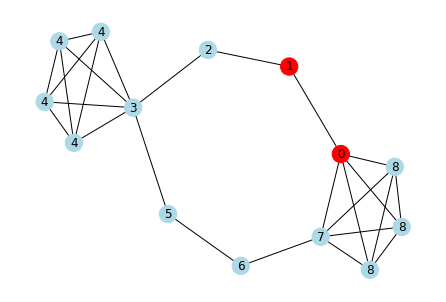

In [20]:
kk=4
aa=0.7
G,H,labels=getGH(kk)
nx.draw(H, nx.kamada_kawai_layout(H), with_labels=True, labels=labels, node_color=["red"]*2+["lightblue"]*(len(H)-2))

Check that this is equivalent to its symbolic counterpart.

In [21]:
numeric_pre = nx.pagerank(G, alpha=aa, tol=1E-10, max_iter=10000)
numeric_post = nx.pagerank(H, alpha=aa, tol=1E-10, max_iter=10000)
for xx in G.nodes():
    expected = ((1 - a) * r_pre[labels[xx]] / det_pre / G.number_of_nodes())(k=kk)(a=aa)
    actual = numeric_pre[xx]
    assert abs(float(expected-actual)) < 1E-9
    expected = ((1 - a) * r_post[labels[xx]] / det_post / G.number_of_nodes())(k=kk)(a=aa)
    actual = numeric_post[xx]
    assert abs(float(expected-actual)) < 1E-9
